# KeyPhrase Extraction using MMR

In [ ]:
pip install transformers

     |████████████████████████████████| 2.5MB 5.2MB/s 
     |████████████████████████████████| 901kB 30.8MB/s 
     |████████████████████████████████| 3.3MB 31.2MB/s 


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
import re
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
python -m spacy download en_core_web_sm

## Initialize

In [ ]:

text = """
         Supervised learning is the machine learning task of 
         learning a function that maps an input to an output based 
         on example input-output pairs.[1] It infers a function 
         from labeled training data consisting of a set of 
         training examples.[2] In supervised learning, each 
         example is a pair consisting of an input object 
         (typically a vector) and a desired output value (also 
         called the supervisory signal). A supervised learning 
         algorithm analyzes the training data and produces an 
         inferred function, which can be used for mapping new 
         examples. An optimal scenario will allow for the algorithm 
         to correctly determine the class labels for unseen 
         instances. This requires the learning algorithm to  
         generalize from the training data to unseen situations 
         in a 'reasonable' way (see inductive bias).
      """

#Number of top keywords
top_k = 5

#To get n_grams
# n_gram_range = (2, 3)
# stop_words = "english"
nltk.download('stopwords')

#STOPWORDS
STOPWORDS = set(list(stopwords.words("english")))
NGRAM_RANGE = (2, 3)

#load spacy and get doc from text
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)

is_stop_word = lambda token: token.is_stop or token.lower_ in STOPWORDS or token.lemma_ in STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Preprocess Steps

In [ ]:
# To clean the text sentences
def clean_token_text(token_text):
    pattern = r'[^A-Za-z0-9]\Z'
    token_text = re.sub(pattern, '', token_text)
    return token_text

##Get candidate keywords

In [ ]:
# Extract candidate words/phrases using n_grams
def extract_all_candidates_from_text():
    count = CountVectorizer(ngram_range=NGRAM_RANGE, stop_words=STOPWORDS).fit([text])
    all_candidates = count.get_feature_names()
    return all_candidates

#Extract only noun phrase chunks
def extract_noun_phrases():
    np_candidates = set()
    for noun_chunk in doc.noun_chunks:
        chunk_text = noun_chunk.text.strip().replace("\n", "").lower()
        chunk_text_tokens = chunk_text.split()
        chunk_text_tokens = [clean_token_text(token_text) for token_text in chunk_text_tokens
                             if token_text not in STOPWORDS]
        #check for stop words using lambda 'is_stop_word'
        if len(chunk_text_tokens) > 0:
            np_candidates.add(' '.join(chunk_text_tokens))
    return np_candidates

#Extract only noun tokens
def extract_single_nouns():
    nouns = set()
    for token in doc:
        token_text = clean_token_text(token.text)
        is_stop = is_stop_word(token)
        if token.pos_ == "NOUN" and len(token_text) > 1 and not is_stop:
            nouns.add(token_text)
    return nouns

#extract noun and noun phrase from the text
def create_candidate():
    nouns = extract_single_nouns()
    noun_phrases = extract_noun_phrases()
    #get union of nouns and noun-phrases
    all_nouns = nouns.union(noun_phrases)
    return all_nouns

#extract all n_grams from the text
all_candidates = extract_all_candidates_from_text()
print("All n_gram keywords: ", all_candidates)

#extract all noun and noun phrase from the text
all_nouns = create_candidate()
print("All nouns & noun phrase keywords: ", all_nouns)

#filter only those n_grams which contains noun or noun-phrase
filtered_candidates = list(filter(lambda candidate : candidate in all_nouns, all_candidates))
print("Final keywords: ", filtered_candidates)

All n_gram keywords:  ['algorithm analyzes', 'algorithm analyzes training', 'algorithm correctly', 'algorithm correctly determine', 'algorithm generalize', 'algorithm generalize training', 'allow algorithm', 'allow algorithm correctly', 'also called', 'also called supervisory', 'analyzes training', 'analyzes training data', 'based example', 'based example input', 'called supervisory', 'called supervisory signal', 'class labels', 'class labels unseen', 'consisting input', 'consisting input object', 'consisting set', 'consisting set training', 'correctly determine', 'correctly determine class', 'data consisting', 'data consisting set', 'data produces', 'data produces inferred', 'data unseen', 'data unseen situations', 'desired output', 'desired output value', 'determine class', 'determine class labels', 'example input', 'example input output', 'example pair', 'example pair consisting', 'examples optimal', 'examples optimal scenario', 'examples supervised', 'examples supervised learning',

##Build Model and Get Embeddings

In [ ]:
#Build model and get embeddings from it.
def build_model(model_name, texts):
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    texts_tokens = tokenizer(texts, padding=True, return_tensors="pt")
    texts_embeddings = model(**texts_tokens)["pooler_output"]
    print(texts_embeddings.shape)
    return texts_embeddings

model_name = "xlm-roberta-base"

#get embeddings for filtered candidates and text
candidates_embeddings = build_model(model_name, filtered_candidates)
text_embeddings = build_model(model_name, [text])

#detach embeddings and get numpy
candidate_embeddings = candidates_embeddings.detach().numpy()
text_embedding = text_embeddings.detach().numpy()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



torch.Size([14, 768])


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 768])


##Algo: MMR, Cosine Similarity

In [ ]:
#consine similarity between candidates embeddings and text embeddings, find top keywords

#Just select top k candidates keywords
def select_topn_candidates():
    distances = cosine_similarity(text_embedding, candidate_embeddings)
    keywords = [filtered_candidates[index] for index in distances.argsort()[0][-top_k:]]
    print(keywords)
    return keywords


# Use MMR(Maximal margin relevance) score to get top keywords, it will have better diversity and relevance
def mmr(text_emb, keywords, keyword_embs, beta=0.55, top_n=10, alias_threshold=0.8):
    """Implementation of Maximal Marginal Relevance to get top N relevant keywords to text
    Args:
        text_emb: embedding of original text (from where keywords are extracted)
        keywords: keywords (noun phrases) selected from text from where we have to choose broad and relevant keywords
        keyword_embs: embeddings of given keywords
        beta: hyper-parameter for MMR score calculations (controls tradeoff between informativeness and diversity)
        top_n: number of top keywords to extract (will return less keywords if len(keywords) < top_n)
        alias_threshold: threshold for cosine similarities (controls alias keyword pairs assignment)
    Returns:
        top_keywords: selected top keywords
        relevance: relevance values for these keywords (relevance of keyword to original text)
        aliases_keywords: aliases for each keyword
    """
    # calculate similarities of keywords with text and between keywords
    text_sims = cosine_similarity(keyword_embs, text_emb)
    keyword_sims = cosine_similarity(keyword_embs)

    # normalize cosine similarities
    text_sims_norm = standard_normalize_cosine_similarities(text_sims)
    keyword_sims_norm = max_normalize_cosine_similarities_pairwise(keyword_sims)

    # keep indices of selected and unselected keywords in list
    selected_keyword_indices = []
    unselected_keyword_indices = list(range(len(keywords)))

    # find the most similar keyword (using original cosine similarities)
    best_idx = np.argmax(text_sims)
    selected_keyword_indices.append(best_idx)
    unselected_keyword_indices.remove(best_idx)

    # do top_n - 1 cycle to select top N keywords
    for _ in range(min(len(keywords), top_n) - 1):
        unselected_keyword_distances_to_text = text_sims_norm[unselected_keyword_indices, :]
        unselected_keyword_distances_pairwise = keyword_sims_norm[unselected_keyword_indices][:,
                                                selected_keyword_indices]

        # if dimension of keywords distances is 1 we add additional axis to the end
        if unselected_keyword_distances_pairwise.ndim == 1:
            unselected_keyword_distances_pairwise = np.expand_dims(unselected_keyword_distances_pairwise, axis=1)

        # find new candidate with
        idx = int(np.argmax(
            beta * unselected_keyword_distances_to_text - (1 - beta) * np.max(unselected_keyword_distances_pairwise,
                                                                              axis=1).reshape(-1, 1)))
        best_idx = unselected_keyword_indices[idx]

        # select new best keyword and update selected/unselected keyword indices list
        selected_keyword_indices.append(best_idx)
        unselected_keyword_indices.remove(best_idx)

    # calculate relevance using original (not normalized) cosine similarities of keywords to text
    relevance = max_normalize_cosine_similarities(text_sims[selected_keyword_indices]).tolist()
    aliases_keywords = get_alias_keywords(keyword_sims[selected_keyword_indices, :], keywords, alias_threshold)

    top_keywords = [keywords[idx] for idx in selected_keyword_indices]

    # for showing vectors in space
    embs = keyword_embs + text_emb
    mask = []

    plot(embs, keywords, mask)

    return top_keywords, relevance, aliases_keywords

##Normalize

In [ ]:
def standard_normalize_cosine_similarities(cosine_similarities):
    """Normalized cosine similarities"""
    # normalize into 0-1 range
    cosine_sims_norm = (cosine_similarities - np.min(cosine_similarities)) / (
            np.max(cosine_similarities) - np.min(cosine_similarities))

    # standardize and shift by 0.5
    cosine_sims_norm = 0.5 + (cosine_sims_norm - np.mean(cosine_sims_norm)) / np.std(cosine_sims_norm)

    return cosine_sims_norm


def max_normalize_cosine_similarities_pairwise(cosine_similarities):
    """Normalized cosine similarities of pairs which is 2d matrix of pairwise cosine similarities"""
    cosine_sims_norm = np.copy(cosine_similarities)
    np.fill_diagonal(cosine_sims_norm, np.NaN)

    # normalize into 0-1 range
    cosine_sims_norm = (cosine_similarities - np.nanmin(cosine_similarities, axis=0)) / (
            np.nanmax(cosine_similarities, axis=0) - np.nanmin(cosine_similarities, axis=0))

    # standardize shift by 0.5
    cosine_sims_norm = \
        0.5 + (cosine_sims_norm - np.nanmean(cosine_sims_norm, axis=0)) / np.nanstd(cosine_sims_norm, axis=0)

    return cosine_sims_norm


def max_normalize_cosine_similarities(cosine_similarities):
    """Normalize cosine similarities using max normalization approach"""
    return 1 / np.max(cosine_similarities) * cosine_similarities.squeeze(axis=1)

def get_alias_keywords(keyword_sims, keywords, threshold):
    """Find keywords in selected list that are aliases (very similar) to each other"""
    similarities = np.nan_to_num(keyword_sims, 0)
    sorted_similarities = np.flip(np.argsort(similarities), 1)

    aliases = []
    for idx, item in enumerate(sorted_similarities):
        alias_for_item = []
        for i in item:
            if similarities[idx, i] >= threshold:
                alias_for_item.append(keywords[i])
            else:
                break
        aliases.append(alias_for_item)

    return aliases

##Plot

In [ ]:
def plot(embs, texts, mask):
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(embs)

    data = pd.DataFrame(
        {'v1': vectors_2d[:, 0],
         'v2': vectors_2d[:, 1],
         #'type': mask
         }
    )

    ax = sns.scatterplot(x=data.v1, y=data.v2) #style=data.type, hue=data.type

    for i, text in enumerate(zip(texts)):
        if len(text) > 20:
            text = text[:20] + '...'
        ax.annotate(text, (vectors_2d[i, 0], vectors_2d[i, 1]))

    plt.show()

##Run Algo

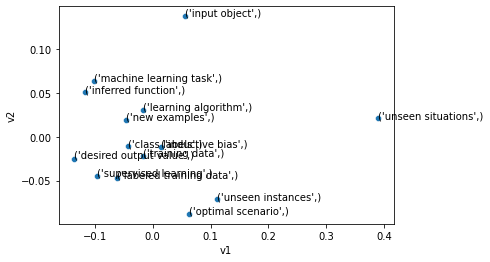

['input object', 'unseen situations', 'new examples', 'learning algorithm', 'training data', 'inferred function', 'class labels', 'inductive bias', 'machine learning task', 'labeled training data']
[1.0, 0.9993218779563904, 0.9996016621589661, 0.9995811581611633, 0.9995240569114685, 0.999370276927948, 0.9993978142738342, 0.9993448853492737, 0.9993128776550293, 0.9992681741714478]
[['input object', 'new examples', 'training data', 'inductive bias', 'learning algorithm', 'class labels', 'labeled training data', 'inferred function', 'optimal scenario', 'machine learning task', 'supervised learning', 'unseen instances', 'desired output value', 'unseen situations'], ['unseen situations', 'unseen instances', 'optimal scenario', 'input object', 'inductive bias', 'training data', 'learning algorithm', 'new examples', 'class labels', 'labeled training data', 'supervised learning', 'machine learning task', 'inferred function', 'desired output value'], ['new examples', 'training data', 'labeled t

In [ ]:
#Trigger keyPhrase extraction algo
top_keywords, relevance, aliases_keywords = mmr(text_embedding, filtered_candidates, candidate_embeddings)
print(top_keywords)
print(relevance)
print(aliases_keywords)